
# http://people.duke.edu/~rnau/411fcst.htm


In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

1.12.9


# Подготавливаем данные

In [2]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

# Предсказание с помощью Facebook Prophet
Для начала построим предсказание с помощью простой библиотеки Facebook Prophet. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [8]:
train_df.tail()

,ds,y
358,2015-12-17,2870
363,2015-12-18,2475
364,2015-12-19,1659
344,2015-12-20,1534
343,2015-12-21,2425


 Далее создаем объект класса Prophet (все параметры модели задаются в конструкторе класса, для начала возьмем default'ные параметры) и обучаем его.

In [9]:
m = Prophet(yearly_seasonality=True)
m.fit(train_df)


С помощью вспомогательной функции Prophet.make_future_dataframe создаем dataframe, который содержит все исторические временные точки и еще 30 дней, для которых мы хотели построить прогноз.

Для того, чтобы построить прогноз вызываем у модели функцию predict и передаем в нее полученный на предыдущем шаге dataframe future.

In [10]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

# 1. Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

In [11]:
import datetime
round(forecast[forecast.ds==datetime.date(2016, 1, 20)].yhat,0)#y с крышкой - это прогноз

382    3833.0
Name: yhat, dtype: float64

## 2. MAPE для модели Prophet по последним 30 дням. 
## 3. MAE для модели Prophet по последним 30 дням. 

In [12]:
import numpy as np

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE', round(np.mean(abs(cmp_df[-predictions:]['p'])),2))
print ('MAE', round(np.mean(abs(cmp_df[-predictions:]['e']))))

MAPE 38.38
MAE 713


## 4. Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным и какое p-value?

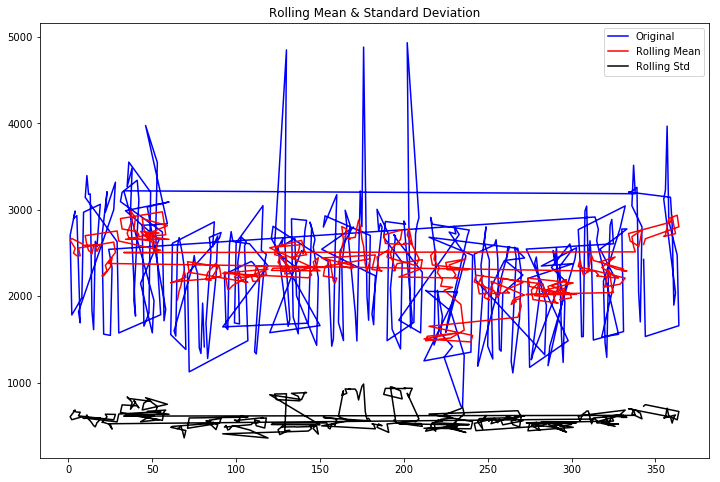

Results of Dickey-Fuller Test:
adf                             -2.534118
p-value                          0.107392
#Lags Used                      15.000000
Number of Observations Used    337.000000
Critical Value (1%)             -3.450000
Critical Value (5%)             -2.870000
Critical Value (10%)            -2.571000
dtype: float64
есть единичные корни, ряд не стационарен


In [13]:
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    warnings.filterwarnings('ignore')

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['adf','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = round(value,3)
    print (dfoutput)
    
    if dfoutput['p-value']> dftest[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')
        
test_stationarity(train_df.y)

# Вопрос 5: Далее перейдем к построению модели SARIMAX (sm.tsa.statespace.SARIMAX). Модель c какими параметрами лучшая по AIC-критерию?

In [14]:
sarima=train_df.set_index('ds')
sarima.index = pd.to_datetime(sarima.index)

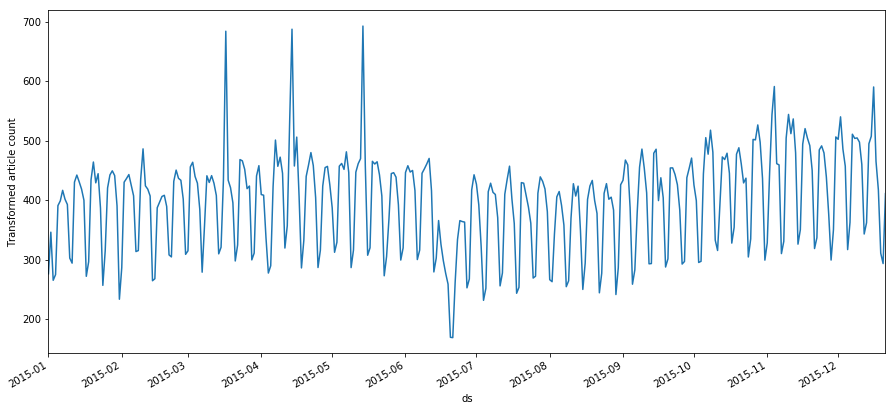

In [15]:
from scipy import stats

sarima['y_box'], lmbda = stats.boxcox(sarima['y'])#stats.boxcox([1 if x == 0 else x for x in sarima['y']])
plt.figure(figsize=(15,7))
sarima.y_box.plot()
plt.ylabel(u'Transformed article count')
#print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sarima['y'])[1])

In [48]:
Ds = range(0,3)
ds = range(0,2)
Qs = range(0,2)
#shift = range(0,140)
q = 2
P = 3
p = 1
ss = range(6,8)
#trends = ['n','c','t','ct']
trends = ['n']

In [49]:
from itertools import product
import statsmodels.api as sm
from tqdm import tqdm

parameters = product(Ds,ds,Qs,ss,trends)#,shift
parameters_list = list(parameters)
len(parameters_list)

24

#plt.figure(figsize=(15,10))
#sm.tsa.seasonal_decompose(sarima.y_box_diff[12:].values, freq=7).plot();
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sarima.y_box_diff[8:])[1])

#sarima.dropna(inplace=True)

In [50]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category=ConvergenceWarning)


pbar = tqdm(total=len(parameters_list))
results = []
best_aic = float("inf")

old_padam=-1
for param in parameters_list:
    pbar.update(1)
    
    #sarima['y_box_diff'] = (sarima.y_box - sarima.y_box.shift(param[4]))
        
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        #order=(p,d,q); seasonal_order=(P,D,Q,s) 
        model=sm.tsa.statespace.SARIMAX(sarima.y_box, order=(p, param[1], q), seasonal_order=(P, param[0], param[2], param[3]),trend=param[4]).fit(disp=False)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except :
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        #print('best_params',list(zip(['D','d','Q','s','trend'],best_param)),'best_aic = ',aic)
    #results.append([param, model.aic])
    
warnings.filterwarnings('default')
pbar.close()

print('-------')
print('best_params',list(zip(['D','d','Q','s','trend'],best_param)))
print(best_aic)
print('D = 1, d = 0, Q = 0')
print('D = 2, d = 1, Q = 1')
print('D = 1, d = 1, Q = 1')
print('D = 0, d = 0, Q = 0')

100%|██████████| 24/24 [00:44<00:00,  3.95s/it]


-------
best_params [('D', 2), ('d', 0), ('Q', 1), ('s', 7), ('trend', 'n')]
3528.65084481
D = 1, d = 0, Q = 0
D = 2, d = 1, Q = 1
D = 1, d = 1, Q = 1
D = 0, d = 0, Q = 0


In [44]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, 1, 7)   Log Likelihood               -1756.325
Date:                           Tue, 09 May 2017   AIC                           3528.651
Time:                                   19:20:56   BIC                           3559.583
Sample:                               01-01-2015   HQIC                          3540.959
                                    - 12-21-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8194      0.118      6.957      0.000       0.589       1.050
ma.L1         -0.3353      0.124     -2.701